<a href="https://colab.research.google.com/github/alexisfrazee/Predict-Future-Sales-DNSC-3288-Project/blob/main/Alexis_DNSC_3288_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Packages

In [1]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

Upload Data

In [11]:
sales = pd.read_csv('sales_train.csv')
test = pd.read_csv('test.csv')

print(sales.head())
print(test.head())

         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0
   ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268


In [ ]:
Aggregate & Add Lags

In [12]:
#v1 of model
# 1. Aggregate daily -> monthly
monthly = (
    sales
    .groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False)
    .agg({'item_cnt_day': 'sum'})
    .rename(columns={'item_cnt_day': 'item_cnt_month'})
)

monthly['item_cnt_month'] = monthly['item_cnt_month'].clip(0, 20).astype('float32')
monthly['date_block_num'] = monthly['date_block_num'].astype('int8')
monthly['shop_id']        = monthly['shop_id'].astype('int16')
monthly['item_id']        = monthly['item_id'].astype('int32')

# 2. All real (shop, item) pairs from train + test
pairs = pd.concat(
    [monthly[['shop_id', 'item_id']], test[['shop_id', 'item_id']]],
    ignore_index=True
).drop_duplicates()

# 3. Build monthly matrix for blocks 0..33
blocks = np.sort(monthly['date_block_num'].unique())

grid = []
for b in blocks:
    tmp = pairs.copy()
    tmp['date_block_num'] = b
    grid.append(tmp)

matrix = pd.concat(grid, ignore_index=True)
matrix['date_block_num'] = matrix['date_block_num'].astype('int8')

# 4. Merge in monthly sales, fill missing with 0 (no normalization)
matrix = matrix.merge(
    monthly,
    on=['date_block_num', 'shop_id', 'item_id'],
    how='left'
)
matrix['item_cnt_month'] = matrix['item_cnt_month'].fillna(0).astype('float32')

# 5. Append test month 34
test_block = test.copy()
test_block['date_block_num'] = 34
test_block['item_cnt_month'] = np.nan

full = pd.concat(
    [matrix[['date_block_num', 'shop_id', 'item_id', 'item_cnt_month']],
     test_block[['date_block_num', 'shop_id', 'item_id', 'item_cnt_month']]],
    ignore_index=True
)

# 6. Calendar + lags
full['month'] = (full['date_block_num'] % 12).astype('int8')
full['year']  = (full['date_block_num'] // 12).astype('int8')

lags = [1, 2, 3, 6, 12]

def add_lag_feature(df, lags, col):
    for lag in lags:
        tmp = df[['date_block_num', 'shop_id', 'item_id', col]].copy()
        tmp['date_block_num'] = tmp['date_block_num'] + lag
        tmp = tmp.rename(columns={col: f'{col}_lag_{lag}'})
        df = df.merge(tmp, on=['date_block_num','shop_id','item_id'], how='left')
    return df

full = add_lag_feature(full, lags, 'item_cnt_month')

lag_cols = [c for c in full.columns if 'item_cnt_month_lag_' in c]
for c in lag_cols:
    full[c] = full[c].fillna(0).astype('float32')


Update Features & Add Lags

In [13]:
#v2 of model
# Only use train months to compute averages (no leakage)
train_mask = full['date_block_num'] < 34

# Item-level mean per month
item_month = (
    full[train_mask]
    .groupby(['date_block_num', 'item_id'], as_index=False)
    ['item_cnt_month'].mean()
    .rename(columns={'item_cnt_month': 'item_month_avg'})
)

# Merge onto full
full = full.merge(item_month, on=['date_block_num', 'item_id'], how='left')
full['item_month_avg'] = full['item_month_avg'].fillna(0).astype('float32')

# Add lags for this aggregated feature
full = add_lag_feature(full, [1, 2, 3, 6, 12], 'item_month_avg')

# Clean up
for col in full.columns:
    if 'item_month_avg_lag_' in col:
        full[col] = full[col].fillna(0).astype('float32')

# Drop current-month version to avoid leakage
full = full.drop(columns=['item_month_avg'])


Train/Test Split

In [14]:
train_full = full[full['date_block_num'] < 34].copy()
test_full  = full[full['date_block_num'] == 34].copy()

y = train_full['item_cnt_month'].clip(0, 20).astype(np.float32)
X = train_full.drop(columns=['item_cnt_month'])

X_test = test_full[X.columns]

# Time-based validation – last month = 33
val_block = 33

X_train = X[train_full['date_block_num'] < val_block]
y_train = y[train_full['date_block_num'] < val_block]

X_val = X[train_full['date_block_num'] == val_block]
y_val = y[train_full['date_block_num'] == val_block]
X_train.shape, X_val.shape

((17388360, 15), (526920, 15))

XGBoost

In [15]:
xgb_model = XGBRegressor(
    max_depth=10,
    n_estimators=500,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    eval_metric='rmse',  # must be here, not in .fit() for xgboost>=2
    n_jobs=-1,
    random_state=42
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=50
)

val_pred = xgb_model.predict(X_val)
val_pred = np.clip(val_pred, 0, 20)
rmse = np.sqrt(mean_squared_error(y_val, val_pred))
print("Validation RMSE:", rmse)


[0]	validation_0-rmse:0.95220	validation_1-rmse:0.76603
[50]	validation_0-rmse:0.73671	validation_1-rmse:0.65776
[100]	validation_0-rmse:0.71636	validation_1-rmse:0.65995
[150]	validation_0-rmse:0.70559	validation_1-rmse:0.66236
[200]	validation_0-rmse:0.69814	validation_1-rmse:0.66287
[250]	validation_0-rmse:0.69196	validation_1-rmse:0.66295
[300]	validation_0-rmse:0.68667	validation_1-rmse:0.66436
[350]	validation_0-rmse:0.68227	validation_1-rmse:0.66478
[400]	validation_0-rmse:0.67815	validation_1-rmse:0.66627
[450]	validation_0-rmse:0.67467	validation_1-rmse:0.66692
[499]	validation_0-rmse:0.67165	validation_1-rmse:0.66722
Validation RMSE: 0.6669395504200435


In [16]:
test_pred = xgb_model.predict(X_test)
test_pred = np.clip(test_pred, 0, 20)

Download submission for Kaggle

In [17]:
submission = pd.DataFrame({
    'ID': test['ID'],
    'item_cnt_month': test_pred
})

submission.to_csv('submission.csv', index=False)
submission.head()

,ID,item_cnt_month
0,0,0.564839
1,1,0.096799
2,2,0.931619
3,3,0.442424
4,4,0.096327


Visuals

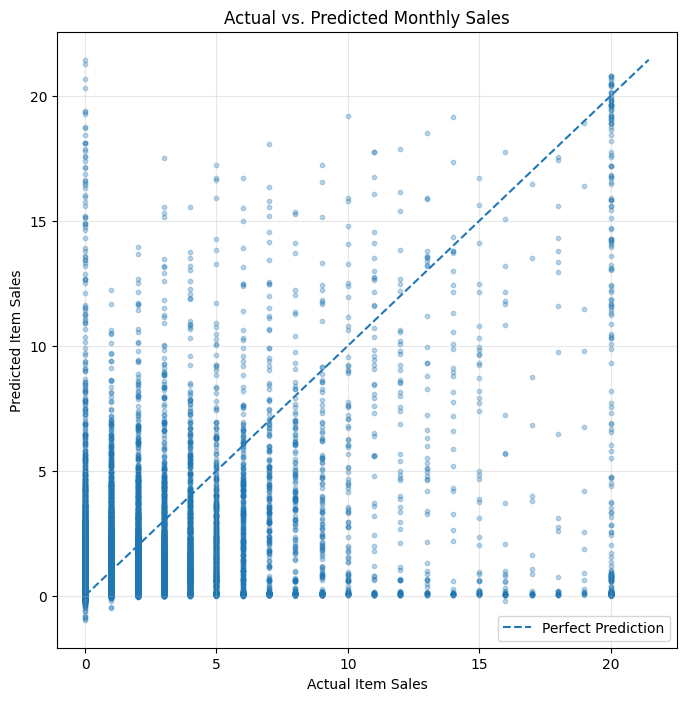

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Get predictions for validation set
val_preds = xgb_model.predict(X_val)
val_true = y_val.values.flatten()

# Scatter plot: Actual vs Predicted
plt.figure(figsize=(8, 8))
plt.scatter(val_true, val_preds, alpha=0.3, s=10)

# 45-degree line for perfect prediction
max_val = max(val_true.max(), val_preds.max())
plt.plot([0, max_val], [0, max_val], linestyle='--', label="Perfect Prediction")

# Labels & title
plt.xlabel("Actual Item Sales")
plt.ylabel("Predicted Item Sales")
plt.title("Actual vs. Predicted Monthly Sales")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Mean of Observations

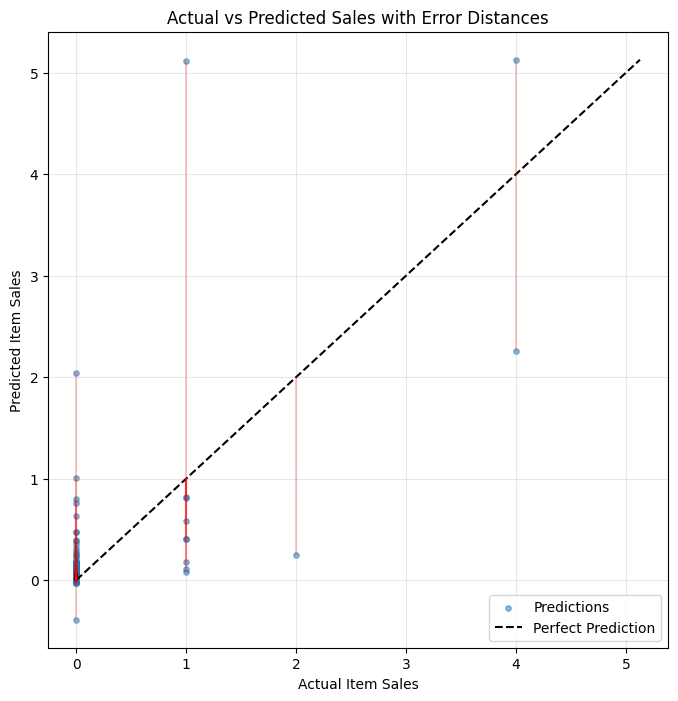

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Predict
val_preds = xgb_model.predict(X_val)
val_true = y_val.values.flatten()

# Limit to 300 random points for visualization clarity
np.random.seed(42)
sample_idx = np.random.choice(len(val_true), size=300, replace=False)

sample_true = val_true[sample_idx]
sample_pred = val_preds[sample_idx]

plt.figure(figsize=(8, 8))

# Scatter actual vs predicted points
plt.scatter(sample_true, sample_pred, alpha=0.5, s=15, label='Predictions')

# Perfect prediction reference line
max_val = max(sample_true.max(), sample_pred.max())
plt.plot([0, max_val], [0, max_val], linestyle='--', color='black', label="Perfect Prediction")

# Draw error lines
for t, p in zip(sample_true, sample_pred):
    plt.plot([t, t], [t, p], color='red', alpha=0.2)

plt.xlabel("Actual Item Sales")
plt.ylabel("Predicted Item Sales")
plt.title("Actual vs Predicted Sales with Error Distances")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
